In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

flower_photo/
  - daisy/
  - dandelion/
  - roses/
  - sunflowers/
  - tulips/

In [2]:
import pathlib
# tar file location
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# creating flower_photos and untar the tar file
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
# length of total images
len(list(data_dir.glob('*/*.jpg')))

3670

### Printing roses images

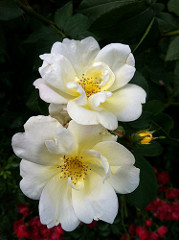

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(roses[0])

### Printing tulips images

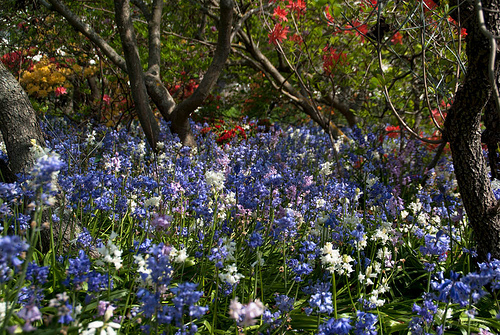

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(tulips[1])

### Load using keras.preprocessing

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_name = train_ds.class_names
class_name

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

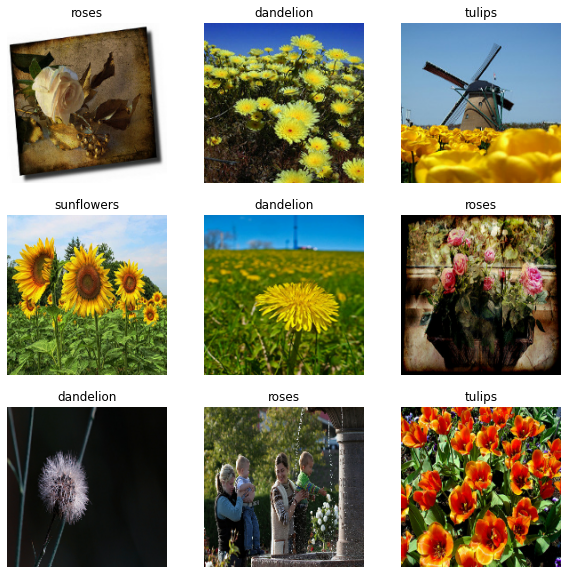

In [10]:
plt.figure(figsize=(10,10))
for image,labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[labels[i]])
        plt.axis('off')

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

### Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=-1)
val_ds = val_ds.cache().prefetch(buffer_size=-1)

### Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

**There are two ways to use this layer. You can apply it to the dataset by calling map:**

In [14]:
normalize_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalize_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9980883


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.



### Create the model
The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [15]:
num_classes = len(class_name)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16,3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

### Compile the model

In [16]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

### Model Summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [18]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

### Train the model

In [19]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 78s 845ms/step - loss: 1.4446 - accuracy: 0.3801 - val_loss: 1.1148 - val_accuracy: 0.5163
Epoch 2/10
92/92 [==============================] - 35s 386ms/step - loss: 1.0226 - accuracy: 0.6104 - val_loss: 1.0284 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 36s 388ms/step - loss: 0.8328 - accuracy: 0.6805 - val_loss: 1.0531 - val_accuracy: 0.5817
Epoch 4/10
92/92 [==============================] - 36s 389ms/step - loss: 0.6923 - accuracy: 0.7422 - val_loss: 0.9628 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 35s 384ms/step - loss: 0.5314 - accuracy: 0.8065 - val_loss: 0.9885 - val_accuracy: 0.6226
Epoch 6/10
92/92 [==============================] - 35s 384ms/step - loss: 0.3498 - accuracy: 0.8804 - val_loss: 1.2173 - val_accuracy: 0.6267
Epoch 7/10
92/92 [==============================] - 37s 407ms/step - loss: 0.2149 - accuracy: 0.9332 - val_loss: 1.3661 - val_accuracy: 0.6308

### Visualize training results
Create plots of loss and accuracy on the training and validation sets.

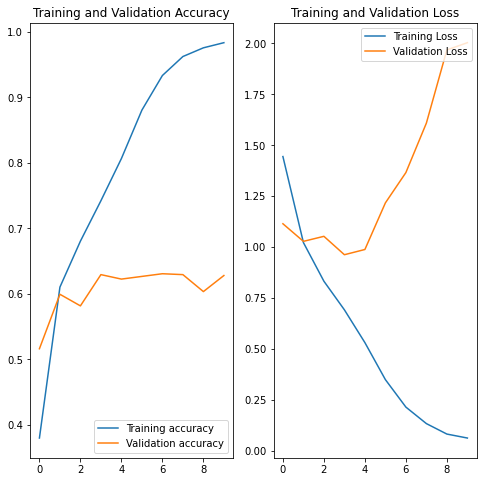

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

### Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

### Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from **tf.keras.layers.experimental.preprocessing**. These can be included inside your model like other layers, and run on the GPU.

In [21]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:



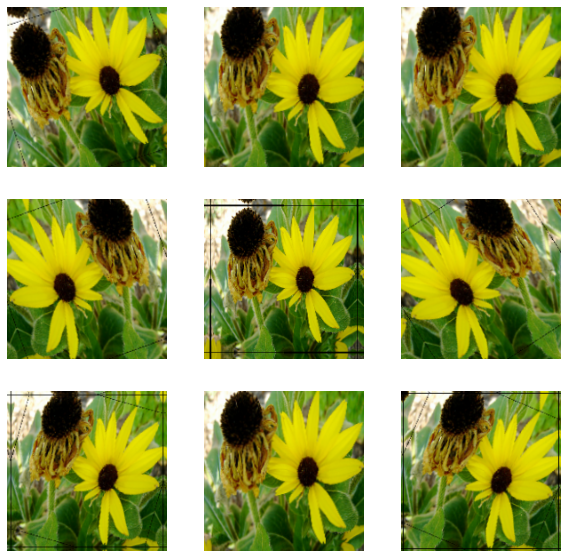

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [23]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 44s 480ms/step - loss: 1.2193 - accuracy: 0.4884 - val_loss: 1.1262 - val_accuracy: 0.5940
Epoch 2/15
92/92 [==============================] - 46s 495ms/step - loss: 0.9828 - accuracy: 0.6185 - val_loss: 0.9885 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 43s 473ms/step - loss: 0.8919 - accuracy: 0.6560 - val_loss: 0.8264 - val_accuracy: 0.6826
Epoch 4/15
92/92 [==============================] - 44s 473ms/step - loss: 0.8259 - accuracy: 0.6744 - val_loss: 0.8318 - val_accuracy: 0.6744
Epoch 5/15
92/92 [==============================] - 44s 480ms/step - loss: 0.7870 - accuracy: 0.6921 - val_loss: 0.8243 - val_accuracy: 0.6935
Epoch 6/15
92/92 [==============================] - 45s 494ms/step - loss: 0.7528 - accuracy: 0.7105 - val_loss: 0.8132 - val_accuracy: 0.6703
Epoch 7/15
92/92 [==============================] - 48s 520ms/step - loss: 0.7265 - accuracy: 0.7197 - val_loss: 0.7854 - val_accuracy: 0.7071

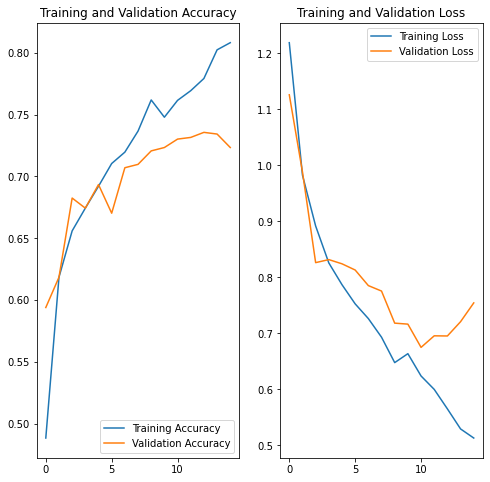

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()